# Определение стоимости автомобилей

Требуется построить модель, способную предсказывать по параметрам автомобиля, его цену на рынке. 

## Подготовка данных

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score


import lightgbm as lgb



In [2]:
data = pd.read_csv('/datasets/autos.csv')

In [3]:
display(data.head())

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [5]:
data.describe()

,Price,RegistrationYear,Power,Kilometer,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


### Краткий вывод

Имеем таблицу 354369 строк на 16 столбцов. Уже заметны пропуски - нужно проверить, также следует заменить заглавные буквы в именах столбцов на прописные для удобства, проверить дубликаты и подготовить данные для обучения моделей. 



In [6]:
data.columns = data.columns.str.lower()
display(data.head())

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


In [7]:
print('Количество пропусков в столбце: "datecrawled" ', data['datecrawled'].isnull().sum())

print('Количество пропусков в столбце: "price" ', data['price'].isnull().sum())

print('Количество пропусков в столбце: "vehicletype" ', data['vehicletype'].isnull().sum())

print('Количество пропусков в столбце: "registrationyear" ', data['registrationyear'].isnull().sum())

print('Количество пропусков в столбце: "gearbox" ', data['gearbox'].isnull().sum())

print('Количество пропусков в столбце: "power" ', data['power'].isnull().sum())

print('Количество пропусков в столбце: "model" ', data['model'].isnull().sum())

print('Количество пропусков в столбце: "kilometer" ', data['kilometer'].isnull().sum())

print('Количество пропусков в столбце: "registrationmonth" ', data['registrationmonth'].isnull().sum())

print('Количество пропусков в столбце: "fueltype" ', data['fueltype'].isnull().sum())

print('Количество пропусков в столбце: "brand" ', data['brand'].isnull().sum())

print('Количество пропусков в столбце: "notrepaired" ', data['notrepaired'].isnull().sum())

print('Количество пропусков в столбце: "datecreated" ', data['datecreated'].isnull().sum())

print('Количество пропусков в столбце: "numberofpictures" ', data['numberofpictures'].isnull().sum())

print('Количество пропусков в столбце: "postalcode" ', data['postalcode'].isnull().sum())

print('Количество пропусков в столбце: "lastseen" ', data['lastseen'].isnull().sum())

print('Всего строк: ', len(data['datecrawled']))

Количество пропусков в столбце: "datecrawled"  0
Количество пропусков в столбце: "price"  0
Количество пропусков в столбце: "vehicletype"  37490
Количество пропусков в столбце: "registrationyear"  0
Количество пропусков в столбце: "gearbox"  19833
Количество пропусков в столбце: "power"  0
Количество пропусков в столбце: "model"  19705
Количество пропусков в столбце: "kilometer"  0
Количество пропусков в столбце: "registrationmonth"  0
Количество пропусков в столбце: "fueltype"  32895
Количество пропусков в столбце: "brand"  0
Количество пропусков в столбце: "notrepaired"  71154
Количество пропусков в столбце: "datecreated"  0
Количество пропусков в столбце: "numberofpictures"  0
Количество пропусков в столбце: "postalcode"  0
Количество пропусков в столбце: "lastseen"  0
Всего строк:  354369


In [8]:
# Итого пропуски в столбцах:
#vehicletype  37490
#gearbox  19833
#model  19705
#fueltype  32895
#notrepaired  71154

Посмотрим на уникальные значения, возможно получится восстановить




In [9]:
print(' Уникальные значения "vehicletype": ', data['vehicletype'].unique(), '\n')

print(' Уникальные значения "gearbox": ', data['gearbox'].unique(), '\n')

print(' Уникальные значения "model": ', data['model'].unique(), '\n')

print(' Уникальные значения "notrepaired": ', data['notrepaired'].unique(), '\n')

print(' Уникальные значения "fueltype": ', data['fueltype'].unique(), '\n')



 Уникальные значения "vehicletype":  [nan 'coupe' 'suv' 'small' 'sedan' 'convertible' 'bus' 'wagon' 'other'] 

 Уникальные значения "gearbox":  ['manual' 'auto' nan] 

 Уникальные значения "model":  ['golf' nan 'grand' 'fabia' '3er' '2_reihe' 'other' 'c_max' '3_reihe'
 'passat' 'navara' 'ka' 'polo' 'twingo' 'a_klasse' 'scirocco' '5er'
 'meriva' 'arosa' 'c4' 'civic' 'transporter' 'punto' 'e_klasse' 'clio'
 'kadett' 'kangoo' 'corsa' 'one' 'fortwo' '1er' 'b_klasse' 'signum'
 'astra' 'a8' 'jetta' 'fiesta' 'c_klasse' 'micra' 'vito' 'sprinter' '156'
 'escort' 'forester' 'xc_reihe' 'scenic' 'a4' 'a1' 'insignia' 'combo'
 'focus' 'tt' 'a6' 'jazz' 'omega' 'slk' '7er' '80' '147' '100' 'z_reihe'
 'sportage' 'sorento' 'v40' 'ibiza' 'mustang' 'eos' 'touran' 'getz' 'a3'
 'almera' 'megane' 'lupo' 'r19' 'zafira' 'caddy' 'mondeo' 'cordoba' 'colt'
 'impreza' 'vectra' 'berlingo' 'tiguan' 'i_reihe' 'espace' 'sharan'
 '6_reihe' 'panda' 'up' 'seicento' 'ceed' '5_reihe' 'yeti' 'octavia' 'mii'
 'rx_reihe' '6er

Уникальных значений моделей и кузовов немного, если потребуется, можно взять каталог моделей и написать функцию, которая по имеющимся данным восстановит конкретную модель и, возможно, даже ее тип кузова.
Временно предлагаю заменить пропущенные значения на 'other'. 

Так как тип топлива восстановить не получится, предлагаю заменить его на 'other'. Категория "other" получится сильно больше, чем должна быть, но даже по каталогу восстановить не получится - так как одна и та же модель с одним и тем же кузовом может быть, например, как на бензине, так и на дизеле (так и на гибриде).

Так же предлагаю заменить пропуски в столбце 'notrepaired' на 'no', то есть как будто машина была в ремонте. Пропусков много, просто удалить нельзя, а информации, чтобы восстановить - нет. Так как машин, которые не были в ремонте, точно меньше тех, что были, а также продавец может специально не указывать факт ремонта, чтобы ввести потенциального покупателя в заблуждение - не думаю, что эта заменя сильно исказит общую картину. 

А пропуски в столбце gearbox заменить на manual - машины на "автомате" обычно стоят дороже, и скорее фак т неуказанной информации говорит о механике.  

In [10]:
data['fueltype'] = data['fueltype'].fillna('other')
print('Количество пропусков в столбце: "fueltype" ', data['fueltype'].isnull().sum())

data['model'] = data['model'].fillna('other')
print('Количество пропусков в столбце: "model" ', data['model'].isnull().sum())

data['gearbox'] = data['gearbox'].fillna('manual')
print('Количество пропусков в столбце: "gearbox" ', data['gearbox'].isnull().sum())


data['notrepaired'] = data['notrepaired'].fillna('no')
print('Количество пропусков в столбце: "notrepaired" ', data['notrepaired'].isnull().sum())

data['vehicletype'] = data['vehicletype'].fillna('other')
print('Количество пропусков в столбце: "vehicletype" ', data['vehicletype'].isnull().sum())

Количество пропусков в столбце: "fueltype"  0
Количество пропусков в столбце: "model"  0
Количество пропусков в столбце: "gearbox"  0
Количество пропусков в столбце: "notrepaired"  0
Количество пропусков в столбце: "vehicletype"  0


In [11]:
#проверим на дубликаты
data.duplicated().sum()

5

In [12]:
data = data.drop_duplicates().reset_index(drop=True)


In [13]:
display(data.head())
data.info()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
0,2016-03-24 11:52:17,480,other,1993,manual,0,golf,150000,0,petrol,volkswagen,no,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354364 entries, 0 to 354363
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   datecrawled        354364 non-null  object
 1   price              354364 non-null  int64 
 2   vehicletype        354364 non-null  object
 3   registrationyear   354364 non-null  int64 
 4   gearbox            354364 non-null  object
 5   power              354364 non-null  int64 
 6   model              354364 non-null  object
 7   kilometer          354364 non-null  int64 
 8   registrationmonth  354364 non-null  int64 
 9   fueltype           354364 non-null  object
 10  brand              354364 non-null  object
 11  notrepaired        354364 non-null  object
 12  datecreated        354364 non-null  object
 13  numberofpictures   354364 non-null  int64 
 14  postalcode         354364 non-null  int64 
 15  lastseen           354364 non-null  object
dtypes: int64(7), object(

In [14]:
#Проверим на выбросы

print(' Уникальные значения "registrationyear": ', data['registrationyear'].unique())





 Уникальные значения "registrationyear":  [1993 2011 2004 2001 2008 1995 1980 2014 1998 2005 1910 2016 2007 2009
 2002 2018 1997 1990 2017 1981 2003 1994 1991 1984 2006 1999 2012 2010
 2000 1992 2013 1996 1985 1989 2015 1982 1976 1983 1973 1111 1969 1971
 1987 1986 1988 1970 1965 1945 1925 1974 1979 1955 1978 1972 1968 1977
 1961 1960 1966 1975 1963 1964 5000 1954 1958 1967 1959 9999 1956 3200
 1000 1941 8888 1500 2200 4100 1962 1929 1957 1940 3000 2066 1949 2019
 1937 1951 1800 1953 1234 8000 5300 9000 2900 6000 5900 5911 1933 1400
 1950 4000 1948 1952 1200 8500 1932 1255 3700 3800 4800 1942 7000 1935
 1936 6500 1923 2290 2500 1930 1001 9450 1944 1943 1934 1938 1688 2800
 1253 1928 1919 5555 5600 1600 2222 1039 9996 1300 8455 1931 1915 4500
 1920 1602 7800 9229 1947 1927 7100 8200 1946 7500 3500]


Предлагаю оставить только те значения, что находятся в промежутке 1900 - 2020

In [15]:
print(data.shape[0])
data = data.query('1900<registrationyear<2020')
print(data.shape[0])

354364
354193


 Уникальные значения "price":  [  480 18300  9800 ... 12395 18429 10985] 



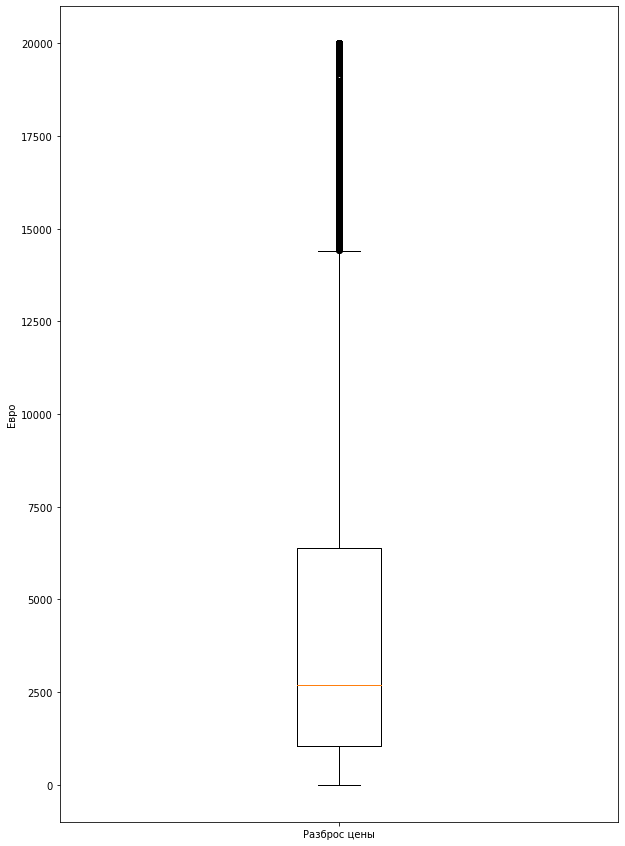

In [16]:
print(' Уникальные значения "price": ', data['price'].unique(), '\n')

fig, ax = plt.subplots(figsize = (10,15))

ax.boxplot(data['price'])

ax.set_xticklabels(['Разброс цены'])
ax.set_ylabel('Евро')
#ax.set_ylim([0,40000])

plt.show()

Предлагаю оставить цены так, как есть. Возможно, машина не на ходу  и поэтому стоит низкая цена ("Лишь бы забрали"), и также возможно, что машина старая и не на ходу, но при этом коллекционная и за нее просят относительно много. 
Если модель будет предсказывать плохо, но можно вернуться и оставить только те машины, которые внутри "усов".

In [17]:
print(' Уникальные значения "power": ', data['power'].unique(), '\n')



 Уникальные значения "power":  [    0   190   163    75    69   102   109    50   125   101   105   140
   115   131    60   136   160   231    90   118   193    99   113   218
   122   129    70   306    95    61   177    80   170    55   143    64
   286   232   150   156    82   155    54   185    87   180    86    84
   224   235   200   178   265    77   110   144   120   116   184   126
   204    88   194   305   197   179   250    45   313    41   165    98
   130   114   211    56   201   213    58   107    83   174   100   220
    85    73   192    68    66   299    74    52   147    65   310    71
    97   239   203     5   300   103   258   320    63    81   148    44
   145   230   280   260   104   188   333   186   117   141    59   132
   234   158    39    92    51   135    53   209    43   146    67   106
   166   276   344    72   249   237   245   111   326   279    23   138
   175    96   226    26    37   301   334   128   133   124    33   219
   241   167    94  

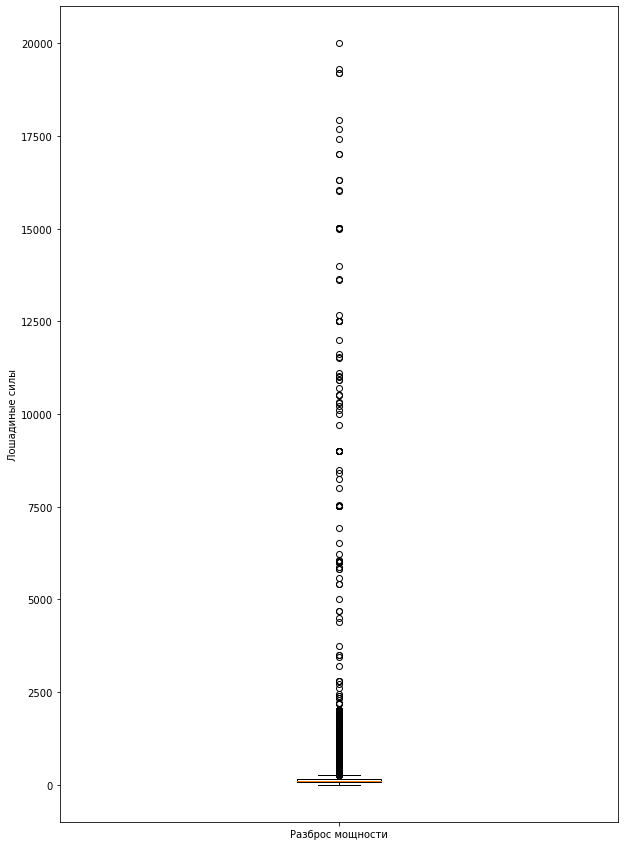

In [18]:
fig, ax = plt.subplots(figsize = (10,15))

ax.boxplot(data['power'])

ax.set_xticklabels(['Разброс мощности'])
ax.set_ylabel('Лошадиные силы')
#ax.set_ylim([0,40000])

plt.show()

Оставляем только значения < 500, если в будущем модель будет плохо обучаться - отбосим все, что не в "усах".

In [19]:
print(data.shape[0])
c = data['power'].quantile(q=0.75)
data = data.query('10<power<500')
print(data.shape[0])

print('75% квантиль', c)

354193
313376
75% квантиль 143.0


In [20]:
print(' Уникальные значения "kilometer": ', data['kilometer'].unique(), '\n')



 Уникальные значения "kilometer":  [125000 150000  90000  40000  30000  70000 100000  60000   5000  20000
  80000  50000  10000] 



Оставляем как есть. 

In [21]:
print(' Уникальные значения "registrationmonth": ', data['registrationmonth'].unique(), '\n')

 Уникальные значения "registrationmonth":  [ 5  8  6  7 10  0 12 11  2  3  1  4  9] 



Месяцев - 12, в таблице - 13. Посчитаем количество значений 0-ого и 12-го месяцев, если 0-ых мало, то просто удалим. Если их больше, чем 12, то перепишем таблицу - "сдвинем" значения на 1 деление вниз. 

In [22]:
data['registrationmonth'].value_counts()

3     31763
6     28981
4     27020
5     26858
7     25001
10    23990
12    22293
11    22045
0     21919
9     21879
1     21150
8     20727
2     19750
Name: registrationmonth, dtype: int64

Так-с, примерно поровну. 
Так как для обучения модели нам хватит года выпуска, а данный столбец вообще не нужен - предлагаю просто не брать его в тестовую выборку. И требуется сообщить заказчику про данную проблему - возможно, ошибка выгрузки. 

## Подготовим обучающую, тестовую и валидационную выборки
в пропорции 60:20:20

In [23]:
data.head()

,datecrawled,price,vehicletype,registrationyear,gearbox,power,model,kilometer,registrationmonth,fueltype,brand,notrepaired,datecreated,numberofpictures,postalcode,lastseen
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,other,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,no,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07


In [24]:
useful_data = data.drop(['datecrawled', 'registrationmonth', 'lastseen',
                         'numberofpictures', 'postalcode', 'datecreated'], axis=1)



In [25]:
target = useful_data['price']
features = useful_data.drop('price', axis=1)


display(features.head())

,vehicletype,registrationyear,gearbox,power,model,kilometer,fueltype,brand,notrepaired
1,coupe,2011,manual,190,other,125000,gasoline,audi,yes
2,suv,2004,auto,163,grand,125000,gasoline,jeep,no
3,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,small,2008,manual,69,fabia,90000,gasoline,skoda,no
5,sedan,1995,manual,102,3er,150000,petrol,bmw,yes


Для замены категориальных переменных на количественные применим OHE:



In [26]:
features_ohe = pd.get_dummies(features, columns=['vehicletype', 'gearbox', 'model', 'fueltype',
                                             'brand', 'notrepaired' ], drop_first=True)





In [27]:
print(features.info())

<class 'pandas.core.frame.DataFrame'>
Int64Index: 313376 entries, 1 to 354363
Data columns (total 9 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   vehicletype       313376 non-null  object
 1   registrationyear  313376 non-null  int64 
 2   gearbox           313376 non-null  object
 3   power             313376 non-null  int64 
 4   model             313376 non-null  object
 5   kilometer         313376 non-null  int64 
 6   fueltype          313376 non-null  object
 7   brand             313376 non-null  object
 8   notrepaired       313376 non-null  object
dtypes: int64(3), object(6)
memory usage: 23.9+ MB
None


Поделим на выборки:

In [28]:
features_train, features_valid_test, target_train, target_valid_test = train_test_split(features_ohe, 
                                                                                        target, test_size=0.4,
                                                                                       random_state = 12345)


features_valid, features_test, target_valid, target_test = train_test_split(features_valid_test, 
                                                                            target_valid_test, test_size=0.5,
                                                                           random_state = 12345)





In [29]:
print('Количество объектов в обучающей, валидационной, тестовой выборках:', features_train.shape[0],
      features_valid.shape[0], features_test.shape[0])


Количество объектов в обучающей, валидационной, тестовой выборках: 188025 62675 62676


## Обучение моделей

Для обучения возьмем случайный лес, градиентный бустинг через библиотеку Light GBM, линейную регрессию. 

Обучим случайный лес

In [30]:
#%%time

#model_TR_simple = RandomForestRegressor(n_jobs=-1)

#model_TR_simple.fit(features_train, target_train)
#predictions_simple = model_TR_simple.predict(features_valid)
#result = mean_squared_error(target_valid, predictions_simple)**(1/2)

#print('Результат обычной модели без измененных гиперпараметров и ее время', result)

In [31]:
#%%time

#scores={}
#for depth in range(1, 20, 1):
#        model_TR = RandomForestRegressor(max_depth=depth,
#                                        n_jobs=-1, random_state=12345)
#        model_TR.fit(features_train, target_train)
#        predictions = model_TR.predict(features_valid)
#        res = mean_squared_error(target_valid, predictions)**(1/2)
#        scores.update({(depth, n_estimator):res})






Начнем подбирать гиперпараметры. Так как это занимает очень много времени, сделаем это через единичные циклы. Так прозе и наглядней. 

In [32]:
#%%time


#scores_depth = {}

#for depth in range (8,40,1):
#    model_FR_depth = RandomForestRegressor(n_jobs=-1, max_depth = depth)
#    model_FR_depth.fit(features_train, target_train)
#    predictions = model_FR_depth.predict(features_valid)
#    res = mean_squared_error(target_valid, predictions)**(1/2)
    
#    scores_depth.update({depth:res})
    
    
    
    
    
    

CPU times: user 8h 39min 4s, sys: 2min, total: 8h 41min 5s  
Wall time: 46min 9s



In [33]:
#best_depth = min(scores_depth, key = scores_depth.get)
#print(best_depth)
#print (scores_depth)

Значит, лучшая глубина - 28

In [34]:
#%%time

#n_estimators_dict = {}


#for n_estimator in range(80,200, 1):
#    model_FR_n_esti = RandomForestRegressor(n_estimators  = n_estimator, max_depth = 28, n_jobs=-1)
#    model_FR_n_esti.fit(features_train, target_train)
#    predictions = model_FR_n_esti.predict(features_valid)
#    result = mean_squared_error(target_valid, predictions)**(1/2)
    
#    n_estimators_dict.update({n_estimator:result})
    
    
    
    

CPU times: user 2d 2h 2min 57s, sys: 12min 12s, total: 2d 2h 15min 10s  
Wall time: 4h 22min 36s




In [35]:
#best_n_estimator = min(n_estimators_dict, key = n_estimators_dict.get)

#print(best_n_estimator)

best_n_estimator = 198

In [36]:
#%%time

#model_RF = RandomForestRegressor(max_depth = 18, n_estimators = 198, n_jobs=-1)
#model_RF.fit(features_train, target_train)
#predictions = model_RF.predict(features_valid)
#score = mean_squared_error(target_valid, predictions)**(1/2)

#print(score)

1768.2906522923724  
CPU times: user 32min 52s, sys: 6.63 s, total: 32min 59s  
Wall time: 2min 51s  

In [37]:
#%%time

#model_LR = LinearRegression( n_jobs=-1)
#model_LR.fit(features_train, target_train)
#predictions = model_LR.predict(features_valid)
#score = mean_squared_error(target_valid, predictions)**(1/2)
#print(score)

2684.9627194293007  
CPU times: user 11 s, sys: 663 ms, total: 11.6 s  
Wall time: 2.68 s  

## Обучим модель градиентным спуском, используя библиотеку LightGBM:

In [38]:
#gbm = lgb.LGBMRegressor(n_jobs=-1, metric = 'mean_squared_error', random_state = 12345, )

In [39]:
#gbm.fit(features_train, target_train)

In [40]:
#predictions = gbm.predict(features_valid)

In [41]:
#score = mean_squared_error(target_valid, predictions)**(1/2)

#print(score)

In [42]:
#%%time

#depths = {}
#for depth in range (10,40,1):
#    gbm = lgb.LGBMRegressor(n_jobs=-1, metric = 'mean_squared_error', random_state = 12345, max_depth = depth)
#    gbm.fit(features_train, target_train)
#    predictions = gbm.predict(features_valid)
#    score = mean_squared_error(target_valid, predictions)**(1/2)
        
#    depths.update({depth:score})


CPU times: user 5min 44s, sys: 15.1 s, total: 5min 59s  
Wall time: 47.5 s  


In [43]:
#best_depth = min(depths, key = depths.get)
#print(best_depth)


Best depth: 21

In [44]:
#%%time

#n_estimators = {}
#for n_estimator in range (10,250,1):
#    gbm = lgb.LGBMRegressor(n_jobs=-1, metric = 'mean_squared_error', random_state = 12345, max_depth = 21, 
#                           n_estimators = n_estimator)
#    gbm.fit(features_train, target_train)
#    predictions = gbm.predict(features_valid)
#    score = mean_squared_error(target_valid, predictions)**(1/2)
        
#    n_estimators.update({n_estimator:score})



CPU times: user 49min 5s, sys: 1min 48s, total: 50min 53s
Wall time: 6min 24s


In [46]:
#best_estimator = min(n_estimators, key = n_estimators.get)
#print(best_estimator)


In [47]:
#%%time

#n_estimators = {}
#for n_estimator in range (249,400,1):
#    gbm = lgb.LGBMRegressor(n_jobs=-1, metric = 'mean_squared_error', random_state = 12345, max_depth = 21, 
#                           n_estimators = n_estimator)
#    gbm.fit(features_train, target_train)
#    predictions = gbm.predict(features_valid)
#    score = mean_squared_error(target_valid, predictions)**(1/2)
        
#    n_estimators.update({n_estimator:score})



In [48]:
#best_estimator = min(n_estimators, key = n_estimators.get)
#print(best_estimator)


In [49]:
#%%time

#leaves = {}

#for leaf in range(3,100,1):
#    gbm = lgb.LGBMRegressor(n_jobs=-1, metric = 'mean_squared_error', random_state = 12345, max_depth = 21, 
#                           n_estimators = 398, num_leaves=leaf)
#    gbm.fit(features_train, target_train)
#    predictions = gbm.predict(features_valid)
#    score = mean_squared_error(target_valid, predictions)**(1/2)
        
#    leaves.update({leaf:score})

In [50]:
#best_leaf = min(leaves, key = leaves.get)
#print(best_leaf,'\n')





In [51]:
#%%time

#gbm_final = lgb.LGBMRegressor(n_jobs=-1, metric='mean_squared_error', random_state = 12345, max_depth = 21,
#                             n_estimators = 398, num_leaves = 99)

#gbm_final.fit(features_train, target_train)
#predictions = gbm_final.predict(features_valid)

#score = mean_squared_error(target_valid, predictions)**(1/2)

#print(score)

1686.9774090161734  
CPU times: user 29.8 s, sys: 593 ms, total: 30.3 s  
Wall time: 3.38 s


## Анализ моделей

### LightGBM

In [52]:
%%time

gbm_final = lgb.LGBMRegressor(n_jobs=-1, metric='mean_squared_error', random_state = 12345, max_depth = 21,
                             n_estimators = 398, num_leaves = 99)
gbm_final.fit(features_train, target_train)




CPU times: user 31.4 s, sys: 1.47 s, total: 32.8 s
Wall time: 3.84 s


LGBMRegressor(max_depth=21, metric='mean_squared_error', n_estimators=398,
              num_leaves=99, random_state=12345)

In [53]:
%%time

predictions_test = gbm_final.predict(features_test)

score_gbm = mean_squared_error(target_test, predictions_test)**(1/2)
print(score_gbm)

1657.5023984234638
CPU times: user 7.23 s, sys: 423 ms, total: 7.65 s
Wall time: 874 ms


### Общий результат LightGBM

Время обучения:

CPU times: user 31.4 s, sys: 1.47 s, total: 32.8 s  
Wall time: 3.84 s  


Время предсказания:

CPU times: user 7.23 s, sys: 423 ms, total: 7.65 s  
Wall time: 874 ms  

Результат:

RMSE = 1657.5023984234638  

### Линейная регрессия

In [54]:
%%time

model_LR = LinearRegression(n_jobs=-1)
model_LR.fit(features_train, target_train)

CPU times: user 11.6 s, sys: 640 ms, total: 12.3 s
Wall time: 2.57 s


LinearRegression(n_jobs=-1)

In [55]:
%%time

predictions_test = model_LR.predict(features_test)

score_LR = mean_squared_error(target_test, predictions_test)**(1/2)
print(score_LR)


2662.0520711356544
CPU times: user 874 ms, sys: 85.1 ms, total: 959 ms
Wall time: 160 ms


### Общий результат Линейной регрессии

Время обучения:

CPU times: user 11.6 s, sys: 640 ms, total: 12.3 s  
Wall time: 2.57 s  


Время предсказания:

CPU times: user 874 ms, sys: 85.1 ms, total: 959 ms  
Wall time: 160 ms   

Результат:

RMSE = 2662.0520711356544

### Случайный лес с подобранными гиперпараметрами

In [58]:
%%time

model_RF = RandomForestRegressor(max_depth = 18, n_estimators = 198, n_jobs=-1)
model_RF.fit(features_train, target_train)

CPU times: user 32min 57s, sys: 6.84 s, total: 33min 4s
Wall time: 2min 53s


RandomForestRegressor(max_depth=18, n_estimators=198, n_jobs=-1)

In [59]:
%%time

predictions_test = model_RF.predict(features_test)

score_RF = mean_squared_error(target_test, predictions_test)**(1/2)
print(score_RF)



1736.443514224792
CPU times: user 4.12 s, sys: 107 ms, total: 4.23 s
Wall time: 519 ms


### Общий результат Случайного леса с подобранными гиперпараметрами

Время обучения:

CPU times: user 32min 57s, sys: 6.84 s, total: 33min 4s  
Wall time: 2min 53s  


Время предсказания:

CPU times: user 4.12 s, sys: 107 ms, total: 4.23 s  
Wall time: 519 ms  

Результат:

RMSE = 1736.443514224792

# Вывод

Исходя из того, что нам важно и скорость обучения, и результат, предлагаю выбрать модель LightGBM, так как она показала лучший результат и приемлемую скорость обучения и предасказания (около 4 секунд, в то время как Случайный лес, который показал практически такой же результат, потратил почти 3 минуты, при этом предсказывает Случайный лес быстрее, но менее точно).
По совокупности факторов предлагаю выбрать LightGBM. 

# Вывод по работе

Данные были загружены, очищены, подготовлены к дальнейшему обучению через OHE, разделены на обучающую, валидационную, тестовую выборки, были рассмотрены 3 модели, подобраны лучшие гиперпараметры для моделей Случайного леса и LightGBM, результат и время обучения и предсказания проанализированы и сделан вывод.